In [2]:

# importing required packages

import pandas as pd
import re
import time
from google.cloud import bigquery
from google.cloud import storage
from datetime import datetime
import google.auth
credentials, project_id = google.auth.default()
from google.auth.transport import requests
from google.oauth2 import service_account
import json
import glob
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import gcsfs

fs = gcsfs.GCSFileSystem(project='data-603')


In [4]:
import pyspark
from pyspark.sql import SparkSession

#spark = SparkSession.builder.appName("answers").getOrCreate()

spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

In [5]:
#path = "gs://flights-603/2009.csv","gs://flights-603/2010.csv"

#df = spark.read.option("inferSchema", "true").option("header", "true").csv(["gs://flights-603/2009.csv","gs://flights-603/2010.csv"])
df= spark.read.option("inferSchema", "true").option("header", "true").csv("gs://flights-603/")


In [6]:
df.count()

61556964

In [7]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

In [8]:
df.limit(1).toPandas()

23/05/15 02:56:34 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-07-03,CO,738,IAH,SAN,1235.0,1237.0,2.0,11.0,1248.0,...,189.0,179.0,164.0,1303.0,NaN,NaN,NaN,NaN,NaN,None


In [9]:
from pyspark.sql.functions import col, sum

# Check the number of null values in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).toPandas()
print(null_counts)


   FL_DATE  OP_CARRIER  OP_CARRIER_FL_NUM  ORIGIN  DEST  CRS_DEP_TIME  \
0        0           0                  0       0     0             1   

   DEP_TIME  DEP_DELAY  TAXI_OUT  WHEELS_OFF  ...  CRS_ELAPSED_TIME  \
0    935723     940675    963901      963896  ...                60   

   ACTUAL_ELAPSED_TIME  AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  \
0              1118754   1118753         0       50166224       50166224   

   NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  Unnamed: 27  
0   50166224        50166224             50166224     61556964  

[1 rows x 28 columns]


In [10]:
cols_to_drop = ['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
df1 = df.drop(*cols_to_drop)


In [11]:
df1.limit(5).toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DIVERTED,DISTANCE
0,2009-05-04,AS,LGB,SEA,-4.0,3.0,0.0,0.0,965.0
1,2009-05-04,AS,PHX,SEA,2.0,29.0,0.0,0.0,1107.0
2,2009-05-04,AS,SEA,SAN,-5.0,-5.0,0.0,0.0,1050.0
3,2009-05-04,AS,SEA,ANC,3.0,-15.0,0.0,0.0,1449.0
4,2009-05-04,AS,SEA,LAS,-10.0,-13.0,0.0,0.0,866.0


In [12]:
from pyspark.sql.functions import col, sum

# Check the number of null values in each column
null_counts = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns]).toPandas()
print(null_counts)


   FL_DATE  OP_CARRIER  ORIGIN  DEST  DEP_DELAY  ARR_DELAY  CANCELLED  \
0        0           0       0     0     940675    1121351          0   

   DIVERTED  DISTANCE  
0         0         0  


In [13]:
from pyspark.sql.functions import col

# Replace null values with zero in the DataFrame
df1 = df1.fillna(0)

# Show the DataFrame with null values replaced
df1.show()


+----------+----------+------+----+---------+---------+---------+--------+--------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|DEP_DELAY|ARR_DELAY|CANCELLED|DIVERTED|DISTANCE|
+----------+----------+------+----+---------+---------+---------+--------+--------+
|2009-01-01|        XE|   DCA| EWR|     -2.0|      4.0|      0.0|     0.0|   199.0|
|2009-01-01|        XE|   EWR| IAD|     -1.0|     -8.0|      0.0|     0.0|   213.0|
|2009-01-01|        XE|   EWR| DCA|     -1.0|     -9.0|      0.0|     0.0|   199.0|
|2009-01-01|        XE|   DCA| EWR|      9.0|    -12.0|      0.0|     0.0|   199.0|
|2009-01-01|        XE|   IAD| EWR|    -10.0|    -38.0|      0.0|     0.0|   213.0|
|2009-01-01|        XE|   ATL| EWR|     -2.0|    -19.0|      0.0|     0.0|   745.0|
|2009-01-01|        XE|   CLE| ATL|     -8.0|    -17.0|      0.0|     0.0|   554.0|
|2009-01-01|        XE|   DCA| EWR|     -7.0|     -8.0|      0.0|     0.0|   199.0|
|2009-01-01|        XE|   EWR| DCA|     -5.0|    -15.0|      0.0|     0.0|  

In [13]:
from pyspark.sql.functions import col, sum

# Check the number of null values in each column
null_counts = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns]).toPandas()
print(null_counts)


   FL_DATE  OP_CARRIER  ORIGIN  DEST  DEP_DELAY  ARR_DELAY  CANCELLED  \
0        0           0       0     0          0          0          0   

   DIVERTED  DISTANCE  
0         0         0  


In [14]:
'''
from pyspark.sql.functions import isnan, col, sum

df1.select([sum(isnan(c).cast("int")).alias(c) for c in df1.columns]).show()
'''


'\nfrom pyspark.sql.functions import isnan, col, sum\n\ndf1.select([sum(isnan(c).cast("int")).alias(c) for c in df1.columns]).show()\n'

### Bar Chart - Count of Flights by Carrier


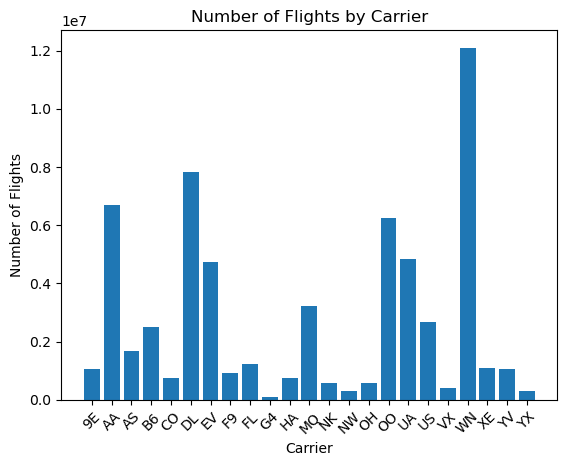

In [15]:
import matplotlib.pyplot as plt

# Count the number of flights per carrier
carrier_counts = df1.groupBy("OP_CARRIER").count().orderBy("OP_CARRIER")

# Extract carrier names and counts
carriers = carrier_counts.select("OP_CARRIER").rdd.flatMap(lambda x: x).collect()
counts = carrier_counts.select("count").rdd.flatMap(lambda x: x).collect()

# Create a bar chart
plt.bar(carriers, counts)
plt.xlabel("Carrier")
plt.ylabel("Number of Flights")
plt.title("Number of Flights by Carrier")
plt.xticks(rotation=45)
plt.show()


### Line Chart - Average Arrival Delay by Date

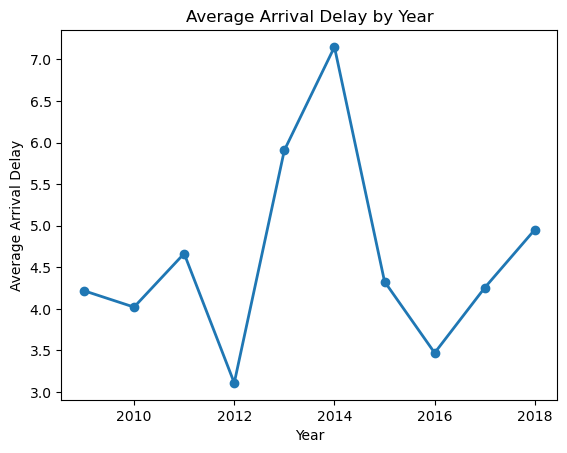

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year

# Extract year from FL_DATE column
df_with_year = df1.withColumn("Year", year("FL_DATE"))

# Calculate the average arrival delay by year
avg_delay_by_year = df_with_year.groupBy("Year").avg("ARR_DELAY").orderBy("Year")

# Extract years and average delays
years = avg_delay_by_year.select("Year").rdd.flatMap(lambda x: x).collect()
avg_delays = avg_delay_by_year.select("avg(ARR_DELAY)").rdd.flatMap(lambda x: x).collect()

# Create a line chart
plt.plot(years, avg_delays, marker='o', linestyle='-', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay")
plt.title("Average Arrival Delay by Year")
plt.show()


### Top 10 airports by departure count

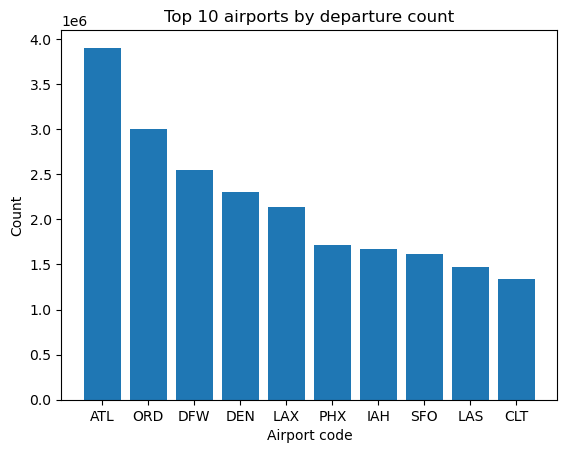

In [17]:
import matplotlib.pyplot as plt

count_by_origin = df1.groupBy("ORIGIN").count().orderBy("count", ascending=False).limit(10)
origin_list = [row["ORIGIN"] for row in count_by_origin.collect()]
count_list = [row["count"] for row in count_by_origin.collect()]

plt.bar(origin_list, count_list)
plt.title("Top 10 airports by departure count")
plt.xlabel("Airport code")
plt.ylabel("Count")
plt.show()


### Proportion of flights cancelled

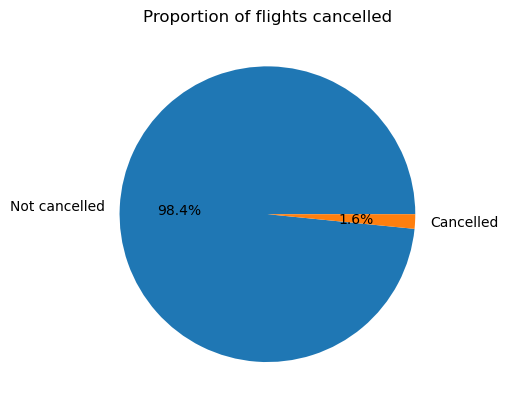

In [19]:
cancelled_counts = df1.groupBy("CANCELLED").count().orderBy("CANCELLED")
labels = ["Not cancelled", "Cancelled"]
values = [row["count"] for row in cancelled_counts.collect()]

plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Proportion of flights cancelled")
plt.show()


### Average arrival delay by carrier

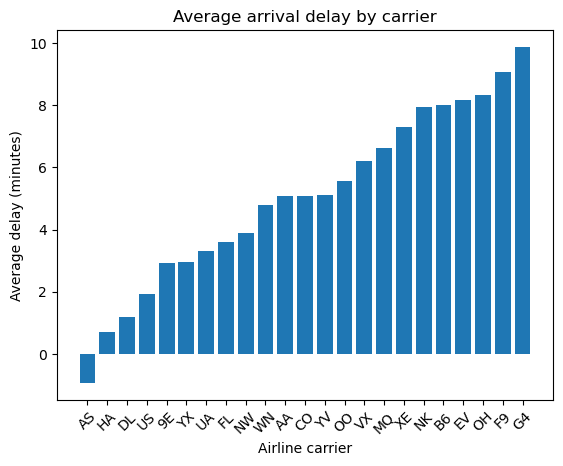

In [34]:
from pyspark.sql.functions import avg, year, month

avg_delay_by_carrier = df1.groupBy("OP_CARRIER").agg(avg("ARR_DELAY").alias("avg_arr_delay")).orderBy("avg_arr_delay")
carrier_list = [row["OP_CARRIER"] for row in avg_delay_by_carrier.collect()]
delay_list = [row["avg_arr_delay"] for row in avg_delay_by_carrier.collect()]

avg_delay_by_carrier = df1.groupBy("OP_CARRIER").agg(avg("ARR_DELAY").alias("avg_arr_delay")).orderBy("avg_arr_delay")

carrier_list = [row["OP_CARRIER"] for row in avg_delay_by_carrier.collect()]
delay_list = [row["avg_arr_delay"] for row in avg_delay_by_carrier.collect()]

plt.bar(carrier_list, delay_list)
plt.title("Average arrival delay by carrier")
plt.xlabel("Airline carrier")
plt.ylabel("Average delay (minutes)")
plt.xticks(rotation=45)
plt.show()


### Average flight distance by month

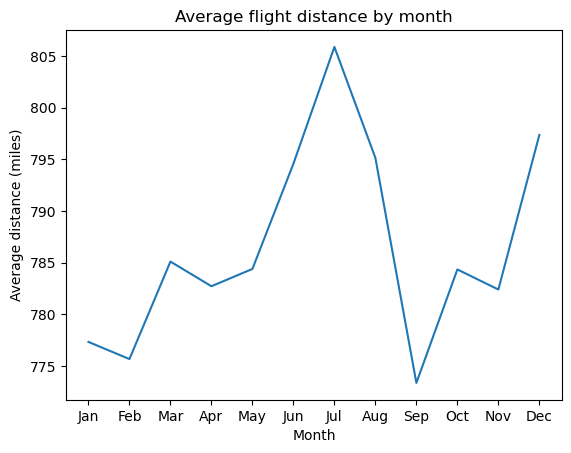

In [33]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import month
from pyspark.sql.functions import avg
from pyspark.sql import Row

# Define month names
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group by month, calculate average distance
avg_distance_by_month = df1.groupBy(month("FL_DATE").alias("month")) \
                           .agg(avg("DISTANCE").alias("avg_distance")) \
                           .orderBy("month")

# Extract month and average distance values
rows = avg_distance_by_month.collect()
x = [month_list[row["month"]-1] for row in rows]
y = [row["avg_distance"] for row in rows]

# Create a line chart
plt.plot(x, y)
plt.title("Average flight distance by month")
plt.xlabel("Month")
plt.ylabel("Average distance (miles)")
plt.show()


### Airport with the largest number of departure flight

In [23]:
from pyspark.sql.functions import desc

# group by origin airport and count number of flights
departure_counts = df1.groupBy("ORIGIN").count()


# sort by count in descending order and show the top result
busiest_origin = departure_counts.orderBy(desc("count")).first()["ORIGIN"]

print(f"The airport with the largest number of departure flights is {busiest_origin}")


The airport with the largest number of departure flights is ATL


In [24]:


# sort by count in descending order and show the top result
busiest_origin = df1.groupBy("ORIGIN").count().orderBy(desc("count"))

In [25]:
busiest_origin.show()

+------+-------+
|ORIGIN|  count|
+------+-------+
|   ATL|3903244|
|   ORD|3001285|
|   DFW|2546075|
|   DEN|2300550|
|   LAX|2133445|
|   PHX|1720614|
|   IAH|1672053|
|   SFO|1612933|
|   LAS|1472436|
|   CLT|1334522|
|   DTW|1290013|
|   MSP|1258951|
|   MCO|1227400|
|   EWR|1182327|
|   BOS|1171494|
|   SLC|1146480|
|   SEA|1142246|
|   LGA|1080902|
|   JFK|1058511|
|   BWI|1003452|
+------+-------+
only showing top 20 rows



### Airport with the largest number of Arrival flights

In [26]:
from pyspark.sql.functions import desc

# group by destination airport and count number of flights
arrival_counts = df1.groupBy("DEST").count()

# sort by count in descending order and show the top result
busiest_dest = arrival_counts.orderBy(desc("count")).first()["DEST"]

print(f"The airport with the largest number of arriving flights is {busiest_dest}")


The airport with the largest number of arriving flights is ATL


### Finding the Busiest Airport



In [14]:
from pyspark.sql.functions import desc


depart_counts = df1.groupBy("ORIGIN").count().withColumnRenamed("count", "depart_count")
arrival_counts = df1.groupBy("DEST").count().withColumnRenamed("count", "arrival_count")


airport_counts = depart_counts.join(arrival_counts, depart_counts.ORIGIN == arrival_counts.DEST)


airport_counts = airport_counts.withColumn("total_count", airport_counts["depart_count"] + airport_counts["arrival_count"])


busiest_airport = airport_counts.orderBy(desc("total_count")).first()["ORIGIN"]

print(f"The busiest airport is {busiest_airport}")


The busiest airport is ATL


In [19]:
busy_airport = airport_counts.orderBy(desc("total_count"))
busy_airport

ORIGIN,depart_count,DEST,arrival_count,total_count
ATL,3903244,ATL,3903288,7806532
ORD,3001285,ORD,3001372,6002657
DFW,2546075,DFW,2546050,5092125
DEN,2300550,DEN,2300456,4601006
LAX,2133445,LAX,2133646,4267091
PHX,1720614,PHX,1720588,3441202
IAH,1672053,IAH,1672279,3344332
SFO,1612933,SFO,1613144,3226077
LAS,1472436,LAS,1472477,2944913
CLT,1334522,CLT,1334543,2669065


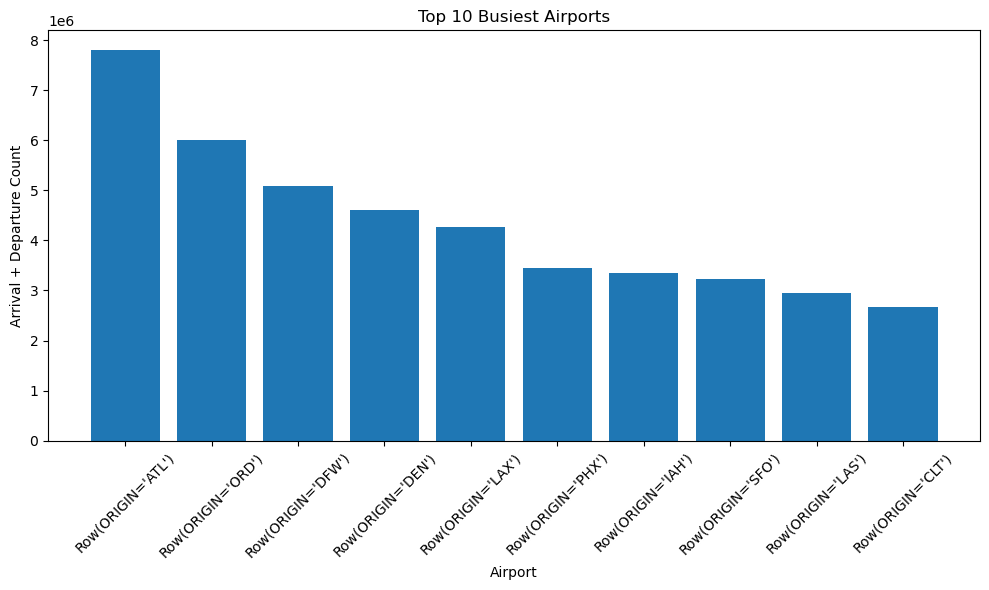

In [25]:
import matplotlib.pyplot as plt

top_10_airports = busy_airport.limit(10)


# Convert the NumPy arrays to Python lists
origin_list = top_10_airports.select("ORIGIN").collect()
count_list = top_10_airports.select("total_count").collect()

# Convert count_list to a regular Python list
count_list = [count[0] for count in count_list]

# Create a bar chart for Arrival + Departure Count
plt.figure(figsize=(10, 6))
plt.bar([str(origin) for origin in origin_list], count_list)
plt.xlabel("Airport")
plt.ylabel("Arrival + Departure Count")
plt.title("Top 10 Busiest Airports")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### Listing top 10 airports with most departure delays in the future

In [28]:
from pyspark.sql.functions import desc
delayed_departures = df1.filter(df.DEP_DELAY > 0)
airport_delays = delayed_departures.groupBy("ORIGIN").avg("DEP_DELAY").withColumnRenamed("avg(DEP_DELAY)", "avg_delay")
top_10_airports = airport_delays.orderBy(desc("avg_delay")).limit(10)
# display the results
top_10_airports.show()


+------+-----------------+
|ORIGIN|        avg_delay|
+------+-----------------+
|   ENV|            157.0|
|   PPG|97.37857142857143|
|   SLN|94.34634146341463|
|   LBL|84.56989247311827|
|   CKB|84.27642276422765|
|   SHD|80.10471204188482|
|   DVL|75.36909090909091|
|   CGI|74.41891891891892|
|   ART|70.46437994722955|
|   PIB|68.80313837375178|
+------+-----------------+



### Listing top 10 airports with most arrival delays in the future

In [29]:
from pyspark.sql.functions import desc
delayed_arrivals = df1.filter(df.ARR_DELAY > 0)
airport_delays = delayed_arrivals.groupBy("DEST").avg("ARR_DELAY").withColumnRenamed("avg(ARR_DELAY)", "avg_delay")
top_10_airports = airport_delays.orderBy(desc("avg_delay")).limit(10)
top_10_airports.show()


+----+------------------+
|DEST|         avg_delay|
+----+------------------+
| SHD| 73.66094420600858|
| CKB| 68.24705882352941|
| SLN| 62.65338645418327|
| PIB|62.603271983640084|
| YNG|              59.5|
| CGI|58.089385474860336|
| LBL| 56.14935064935065|
| SFB|54.174313990103464|
| PIE| 53.50743626062323|
| BFF|52.803030303030305|
+----+------------------+



In [30]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [31]:
from pyspark.sql.functions import desc

# create a temporary table for the dataframe
df1.createOrReplaceTempView("flights")
#spark.sql("select DEST from flights group by DEST).show()

# filter the dataframe to only include delayed arrivals
delayed_arrivals = spark.sql("SELECT DEST,avg(ARR_DELAY) FROM flights where ARR_DELAY > 0 group by DEST order by avg(ARR_DELAY) DESC ")



# display the results
delayed_arrivals.show()


+----+------------------+
|DEST|    avg(ARR_DELAY)|
+----+------------------+
| SHD| 73.66094420600858|
| CKB| 68.24705882352941|
| SLN| 62.65338645418327|
| PIB|62.603271983640084|
| YNG|              59.5|
| CGI|58.089385474860336|
| LBL| 56.14935064935065|
| SFB|54.174313990103464|
| PIE| 53.50743626062323|
| BFF|52.803030303030305|
| EAR| 51.13513513513514|
| FOE|  50.7071129707113|
| PGV| 49.81704260651629|
| PUB| 49.22641509433962|
| TTN| 48.92905672302101|
| PGD| 48.28943820224719|
| UST|48.190871369294605|
| APN| 47.86070686070686|
| USA| 47.34011627906977|
| EWR|  47.3098224529484|
+----+------------------+
only showing top 20 rows



### Carriers with most  Cancellations

In [40]:

from pyspark.sql.functions import count
carrier_cancellation_count = df1.groupBy("OP_CARRIER").agg(count("CANCELLED").alias("cancellation_count"))
sorted_carrier_cancellation_count = carrier_cancellation_count.orderBy("cancellation_count", ascending=False)
# Show the cancellation count of carriers
sorted_carrier_cancellation_count.show()

+----------+------------------+
|OP_CARRIER|cancellation_count|
+----------+------------------+
|        WN|          12096540|
|        DL|           7841880|
|        AA|           6682161|
|        OO|           6263052|
|        UA|           4826658|
|        EV|           4726445|
|        MQ|           3216260|
|        US|           2657286|
|        B6|           2483969|
|        AS|           1660539|
|        FL|           1218389|
|        XE|           1105864|
|        9E|           1066251|
|        YV|           1063558|
|        F9|            903218|
|        HA|            744991|
|        CO|            740498|
|        NK|            588574|
|        OH|            577060|
|        VX|            389060|
+----------+------------------+
only showing top 20 rows



In [46]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

### User can check below table to consider the delay and take the best flight

In [60]:
from pyspark.sql.functions import desc

# create a temporary table for the dataframe
df.createOrReplaceTempView("bestflights")
#spark.sql("select DEST from flights group by DEST).show()
#best_flights=spark.sql("SELECT * FROM bestflights ")
# filter the dataframe to only include delayed arrivals
best_flights= spark.sql("SELECT OP_CARRIER,sum(CARRIER_DELAY),sum(DEP_DELAY),sum(ARR_DELAY),sum(WEATHER_DELAY),sum(NAS_DELAY),sum(SECURITY_DELAY),sum(LATE_AIRCRAFT_DELAY) FROM bestflights group by OP_CARRIER order by sum(CARRIER_DELAY),sum(DEP_DELAY),sum(ARR_DELAY),sum(WEATHER_DELAY),sum(NAS_DELAY),sum(SECURITY_DELAY),sum(LATE_AIRCRAFT_DELAY) ASC")



# display the results
best_flights.show()


+----------+------------------+--------------+--------------+------------------+--------------+-------------------+------------------------+
|OP_CARRIER|sum(CARRIER_DELAY)|sum(DEP_DELAY)|sum(ARR_DELAY)|sum(WEATHER_DELAY)|sum(NAS_DELAY)|sum(SECURITY_DELAY)|sum(LATE_AIRCRAFT_DELAY)|
+----------+------------------+--------------+--------------+------------------+--------------+-------------------+------------------------+
|        G4|          582255.0|     1233757.0|      950351.0|           88734.0|      223250.0|             3559.0|                667966.0|
|        YX|          805672.0|     2248562.0|      939165.0|          181742.0|     1294023.0|             2442.0|               1351063.0|
|        VX|          837394.0|     4057797.0|     2412155.0|          245503.0|     2101557.0|            18639.0|               1692431.0|
|        NW|         1035369.0|     1660528.0|     1138401.0|          192833.0|      828914.0|             3677.0|                625882.0|
|        NK| 

### Adding all the delays and sorting them to get flights with less delays

In [66]:
from pyspark.sql.functions import desc

# create a temporary table for the dataframe
df.createOrReplaceTempView("bestflights")
#spark.sql("select DEST from flights group by DEST).show()
#best_flights=spark.sql("SELECT * FROM bestflights ")
# filter the dataframe to only include delayed arrivals
query = """
       SELECT OP_CARRIER,
           sum(CARRIER_DELAY + DEP_DELAY + ARR_DELAY + WEATHER_DELAY + NAS_DELAY + SECURITY_DELAY + LATE_AIRCRAFT_DELAY) AS TOTAL_DELAY
    FROM bestflights
    GROUP BY OP_CARRIER
    ORDER BY TOTAL_DELAY ASC
"""

result = spark.sql(query)
#best_flights= spark.sql("SELECT OP_CARRIER,(CARRIER_DELAY + DEP_DELAY + ARR_DELAY + WEATHER_DELAY + NAS_DELAY + SECURITY_DELAY + LATE_AIRCRAFT_DELAY) AS TOTAL_DELAY FROM bestflightsGROUP BY OP_CARRIER ORDER BY TOTAL_DELAY ASC;")



# display the results
result.show()


+----------+------------+
|OP_CARRIER| TOTAL_DELAY|
+----------+------------+
|        G4|   4613248.0|
|        NW|   7449538.0|
|        HA|   7725111.0|
|        YX| 1.0430901E7|
|        VX| 1.4179382E7|
|        CO| 2.1284384E7|
|        OH| 2.2667908E7|
|        NK| 2.5394216E7|
|        AS|  3.001489E7|
|        FL| 3.1822233E7|
|        9E|   3.21429E7|
|        YV| 3.2629039E7|
|        F9| 3.6657217E7|
|        XE| 3.8275153E7|
|        US| 5.8673353E7|
|        B6|1.08334526E8|
|        MQ|1.09621806E8|
|        UA|1.67193496E8|
|        EV|2.00414761E8|
|        DL|2.04386647E8|
+----------+------------+
only showing top 20 rows

